In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from itertools import chain
from sklearn.preprocessing import minmax_scale
from scipy.stats import linregress, spearmanr, pearsonr
plt.rcParams['figure.figsize'] = [15, 10]
import warnings; warnings.simplefilter('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: cortex_aba_energy_3s.csv,lambdas_pmeans_dapi.tsv, 10015CN89*C1*annotations.txt, 10015CN89*D1*annotations.txt,
# 10015CN89*E1*annotations.txt,10015CN90*annotations.txt, lambdas_pmeans_output_visium.tsv, visium*annotations.txt


Load definitions

In [4]:
def Extract(lst): 
    return list(next(zip(*lst))) 

def rename_lambdas_index(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [61]:
# Load ABA ref files
path = '../../smomics_data/'
aba_spec = pd.read_csv(os.path.join(path, 'cortex_aba_energy_3s.csv'), index_col=0)


In [62]:
# Pick genes to correlate to SM-Omics signals per region
genes = ['Adora2a', 'Cabp7','Slc6a11', 'Ier5', 'Slc17a6', 'Grem2']


In [63]:
# Load SM-Omics data for Cortex

In [64]:
# Load Lambda pmean df
path = '../../smomics_data/'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_dapi.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1], low_memory = False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [65]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [66]:
annot_path = '../../smomics_data'

annot_list = []

for stdata in list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns])):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)
annotdf = annotdf[annotdf['value'] != 'Unknown']
annotdf['region'] = annotdf['value'].replace({'Cerebral nuclei':'CNU',
                    'Cortical subplate':'CTXSP',
                    'Fiber tracts': 'nan',
                    'Hippocampal formation': 'HIP',
                    'Hypothalamus':'HY',
                    'Isocortex':'ISOCORTEX',
                    'Midbrain':'TH',
                    'Olfactory areas':'PIR',
                    'Thalamus':'TH',
                    'Rest':'Rest'})

# subset to have only regions that have annotated genes in aba 
annotdf = annotdf[annotdf['region'].isin(['CTXSP', 'HIP', 'HY', 'ISOCORTEX', 'PIR', 'TH'])]

In [67]:
list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns]))

['10015CN89_C1',
 '10015CN89_D1',
 '10015CN89_E1',
 '10015CN90_C1',
 '10015CN90_C2',
 '10015CN90_D1',
 '10015CN90_D2',
 '10015CN90_E1',
 '10015CN90_E2']

In [68]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'sm-omics'       

In [69]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in aba_spec.index:
        abs_gene = aba_spec.loc[gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('region')['aba-mean'].mean())).transform(lambda x: minmax_scale(x))['aba-mean']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('region')['aba-mean'].mean().index
aba_df['Condition'] = 'aba'

In [70]:
aba_df

,Adora2a,Cabp7,Slc6a11,Ier5,Slc17a6,Grem2,Condition
region,,,,,,,
CTXSP,1.000000,0.000000,0.105601,0.095532,0.126686,0.293837,aba
HIP,0.000000,1.000000,0.050820,0.305914,0.045921,0.339563,aba
HY,0.001411,0.039813,1.000000,0.000000,0.502093,0.066346,aba
ISOCORTEX,0.058798,0.003898,0.000000,1.000000,0.000000,0.182417,aba
PIR,0.126548,0.004565,0.411112,0.145724,0.058938,1.000000,aba
TH,0.001320,0.179721,0.460656,0.016705,1.000000,0.000000,aba


In [71]:
np.unique(aba_df.columns) == np.unique(sm_df.columns)

array([ True,  True,  True,  True,  True,  True,  True])

In [72]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'sm-omics']
corr_df['region'] = list(np.unique(abs_gene.groupby('region')['aba-mean'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('region')['aba-mean'].mean().index)]
corr_df = corr_df.fillna(0)

In [73]:
np.unique(corr_df['gene'])

array(['Adora2a', 'Cabp7', 'Grem2', 'Ier5', 'Slc17a6', 'Slc6a11'],
      dtype=object)

Adora2a
Adora2a
Spearman's r: 0.714
Spearman's p value: 0.1107871720116617
Cabp7
Cabp7
Spearman's r: 0.771
Spearman's p value: 0.07239650145772594
Slc6a11
Slc6a11
Spearman's r: 1.0
Spearman's p value: 0.0
Ier5
Ier5
Spearman's r: 0.829
Spearman's p value: 0.04156268221574334
Slc17a6
Slc17a6
Spearman's r: 1.0
Spearman's p value: 0.0
Grem2
Grem2
Spearman's r: 0.257
Spearman's p value: 0.6227871720116618


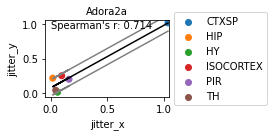

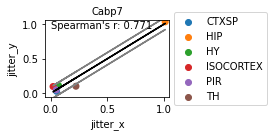

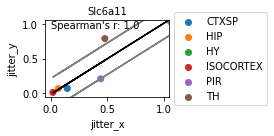

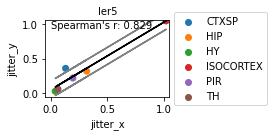

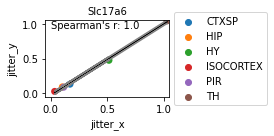

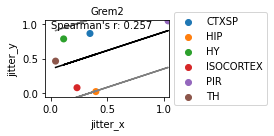

In [74]:
for gene in genes:
    
    # initialize a figure
    fig, ax = plt.subplots(figsize=(4, 2))
    print(gene)

    corr_df_sub = corr_df[corr_df['gene'] == gene]
    
    corr_df_sub['jitter_y'] = corr_df_sub['sm-omics'] + 0.05 * np.random.rand(len(corr_df_sub['sm-omics'].tolist())) +0.01
    corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
    x = 'jitter_x'
    y = 'jitter_y'
    hue = 'region'


    sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    x = 'sm-omics'
    y = 'aba'
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=10)
    ax.set_title(gene, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    #plt.savefig("IFvsGENE_Neun.pdf", transparent=True, bbox_inches = 'tight',
    #    pad_inches = 0, dpi=1200, rasterized=True)

Spearman's r: 0.728
Spearman's p value: 4.860850164165911e-07


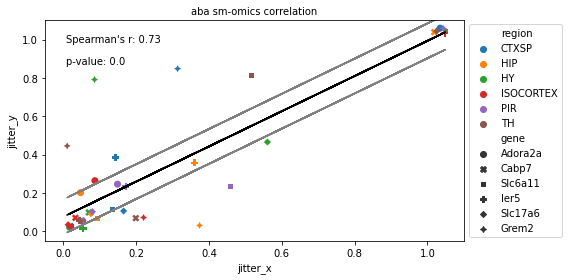

In [75]:
# initialize a figure
fig, ax = plt.subplots(figsize=(8, 4))
corr_df_sub = corr_df

corr_df_sub['jitter_y'] = corr_df_sub['sm-omics'] + 0.05 * np.random.rand(len(corr_df_sub['sm-omics'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, style=style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.1])
ax.set_xlim([-0.05,1.1])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'sm-omics'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba sm-omics correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_smvsvisium_all_genes_correlation.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

Spearman's r: 0.728
Spearman's p value: 4.860850164165911e-07


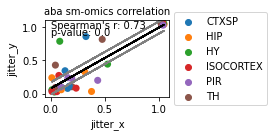

In [41]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))
corr_df_sub = corr_df

corr_df_sub['jitter_y'] = corr_df_sub['sm-omics'] + 0.05 * np.random.rand(len(corr_df_sub['sm-omics'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.1])
ax.set_xlim([-0.05,1.1])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'sm-omics'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba sm-omics correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_smvsvisium_all_genes_correlation_pre_region.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

No handles with labels found to put in legend.


Spearman's r: 0.728
Spearman's p value: 4.860850164165911e-07


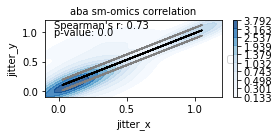

In [42]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))
corr_df_sub = corr_df

corr_df_sub['jitter_y'] = corr_df_sub['sm-omics'] + 0.05 * np.random.rand(len(corr_df_sub['sm-omics'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
corr_df_sub = corr_df

kdeplot = sns.kdeplot(x=x, y=y, data=corr_df_sub, ax=ax, kind = 'kde', alpha = 0.8, cbar = True,
          shade=True, cmap="Blues", shade_lowest=False,)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.1,1.2])
ax.set_xlim([-0.1,1.2])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'sm-omics'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba sm-omics correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_smvsvisium_all_genes_correlation_kde.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

In [ ]:
# Load Visium data for Cortex

In [43]:
# Load Lambda pmean df
path = '../../smomics_data'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_visium.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [44]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [45]:
annot_path = '../../smomics_data'

annot_list = []

for stdata in list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns])):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)
annotdf = annotdf[annotdf['value'] != 'Unknown']
annotdf['region'] = annotdf['value'].replace({'Cerebral nuclei':'CNU',
                    'Cortical subplate':'CTXSP',
                    'Fiber tracts': 'nan',
                    'Hippocampal formation': 'HIP',
                    'Hypothalamus':'HY',
                    'Isocortex':'ISOCORTEX',
                    'Midbrain':'TH',
                    'Olfactory areas':'PIR',
                    'Thalamus':'TH',
                    'Rest':'Rest'})

# subset to have only regions that have annotated genes in aba 
annotdf = annotdf[annotdf['region'].isin(['CTXSP', 'HIP', 'HY', 'ISOCORTEX', 'PIR', 'TH'])]

In [49]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'visium'       

In [50]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in aba_spec.index:
        abs_gene = aba_spec.loc[gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('region')['aba-mean'].mean())).transform(lambda x: minmax_scale(x))['aba-mean']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('region')['aba-mean'].mean().index
aba_df['Condition'] = 'aba'

In [51]:
aba_df

,Adora2a,Cabp7,Slc6a11,Ier5,Slc17a6,Grem2,Condition
region,,,,,,,
CTXSP,1.000000,0.000000,0.105601,0.095532,0.126686,0.293837,aba
HIP,0.000000,1.000000,0.050820,0.305914,0.045921,0.339563,aba
HY,0.001411,0.039813,1.000000,0.000000,0.502093,0.066346,aba
ISOCORTEX,0.058798,0.003898,0.000000,1.000000,0.000000,0.182417,aba
PIR,0.126548,0.004565,0.411112,0.145724,0.058938,1.000000,aba
TH,0.001320,0.179721,0.460656,0.016705,1.000000,0.000000,aba


In [52]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'visium']
corr_df['region'] = list(np.unique(abs_gene.groupby('region')['aba-mean'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('region')['aba-mean'].mean().index)]
corr_df = corr_df.fillna(0)

Adora2a
Adora2a
Spearman's r: 0.714
Spearman's p value: 0.1107871720116617
Cabp7
Cabp7
Spearman's r: 0.771
Spearman's p value: 0.07239650145772594
Slc6a11
Slc6a11
Spearman's r: 0.829
Spearman's p value: 0.04156268221574334
Ier5
Ier5
Spearman's r: 1.0
Spearman's p value: 0.0
Slc17a6
Slc17a6
Spearman's r: 0.886
Spearman's p value: 0.01884548104956266
Grem2
Grem2
Spearman's r: 0.257
Spearman's p value: 0.6227871720116618


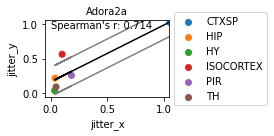

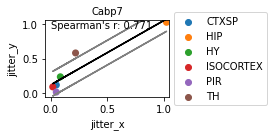

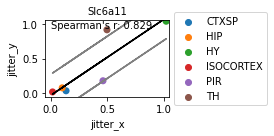

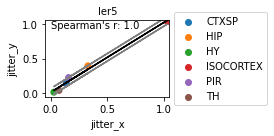

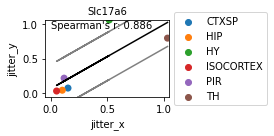

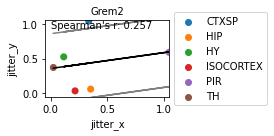

In [53]:
for gene in genes:
    
    # initialize a figure
    fig, ax = plt.subplots(figsize=(4, 2))
    print(gene)
    
    corr_df_sub = corr_df[corr_df['gene'] == gene]
    corr_df_sub['jitter_y'] = corr_df_sub['visium'] + 0.05 * np.random.rand(len(corr_df_sub['visium'].tolist())) +0.01
    corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
    x = 'jitter_x'
    y = 'jitter_y'
    hue = 'region'
    style = 'gene'
    sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    x = 'visium'
    y = 'aba'
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=10)
    ax.set_title(gene, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()



Spearman's r: 0.671
Spearman's p value: 7.454936826957753e-06


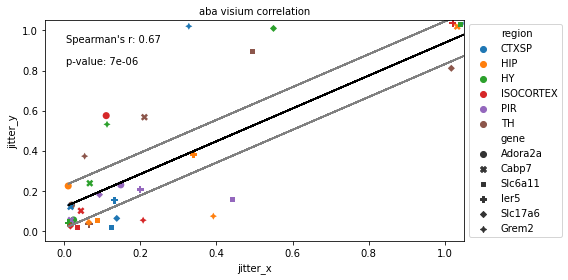

In [60]:
# initialize a figure
fig, ax = plt.subplots(figsize=(8, 4))
corr_df_sub = corr_df
corr_df_sub['jitter_y'] = corr_df_sub['visium'] + 0.05 * np.random.rand(len(corr_df_sub['visium'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
style = 'gene'

sns.scatterplot(x=x, y=y, hue=hue, style=style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'visium'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba visium correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_visium_genes_correlation.pdf", transparent=True, bbox_inches = 'tight',
    pad_inches = 0, dpi=1200, rasterized=True)

Spearman's r: 0.671
Spearman's p value: 7.454936826957753e-06


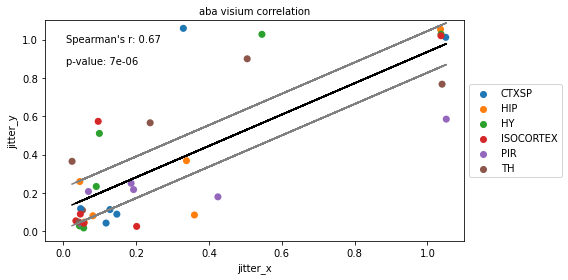

In [58]:
# initialize a figure
fig, ax = plt.subplots(figsize=(8, 4))
corr_df_sub = corr_df

corr_df_sub['jitter_y'] = corr_df_sub['visium'] + 0.05 * np.random.rand(len(corr_df_sub['visium'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.1])
ax.set_xlim([-0.05,1.1])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'visium'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba visium correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_visium_all_genes_correlation_pre_region.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

No handles with labels found to put in legend.


Spearman's r: 0.671
Spearman's p value: 7.454936826957753e-06


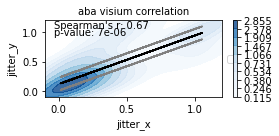

In [56]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))
corr_df_sub = corr_df

corr_df_sub['jitter_y'] = corr_df_sub['visium'] + 0.05 * np.random.rand(len(corr_df_sub['visium'].tolist())) +0.01
corr_df_sub['jitter_x'] = corr_df_sub['aba'] + 0.05 * np.random.rand(len(corr_df_sub['aba'].tolist())) +0.01
x = 'jitter_x'
y = 'jitter_y'
hue = 'region'
corr_df_sub = corr_df

kdeplot = sns.kdeplot(x=x, y=y, data=corr_df_sub, ax=ax, kind = 'kde', alpha = 0.8, cbar = True,
          shade=True, cmap="Blues", shade_lowest=False,)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.1,1.2])
ax.set_xlim([-0.1,1.2])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
x = 'visium'
y = 'aba'
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.8, "p-value: " + str(round(pspear, 6)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba visium correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_visium_all_genes_correlation_kde.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)